# This notebook for preprocessing and deep-learning model model implemented using pytorch of the Devices-Price-Classification-System project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## importing libraries

In [2]:
# installing torchmetrics library to our colab notebook
!pip install torchmetrics

# importing the libraries
import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import joblib
import pickle
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.classification import Accuracy, MulticlassF1Score#, ConfusionMatrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# printing pytorch version as this point may affect the reproducability if diffrent pytorch version used
print(f'using version {torch.__version__}')

# This function to be able to reproduce the same numbers in the future, by fixing
# the algorithms parameters that lead to generate the same random numbers

# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    # set seed for python random numbers.
    random.seed(seed)
    # set seed for numpy random numbers.
    np.random.seed(seed)
    # set seed for pytorch random numbers.
    torch.manual_seed(seed)
    # set seed for cuda.
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# select random seed number
seed=7
# call the function
set_random_seed(seed=seed)

using version 2.3.0+cu121


## load data

In [92]:
df = pd.read_csv("/content/drive/MyDrive/maids.cc/data/train - train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/maids.cc/data/test - test.csv")

split the label column from the feature columns

In [93]:

# label column naming it (y)
y = df["price_range"]
#feature columns naming them x
x = df.drop("price_range", axis=1)
#y.shape, x.shape

#### using train test split function to split the training data into training and validation set

In [94]:
from sklearn.model_selection import train_test_split
xtrain_unprocessed, xtest_unprocessed, ytrain, ytest = train_test_split(
    x, y, test_size=0.15, random_state=seed, stratify=y, shuffle=True)

In [95]:
## initializing the one_hot_encoder
#one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
## apply transformation
#ytrain = one_hot_encoder.fit_transform(ytrain_unprocessed)
#ytest = one_hot_encoder.transform(ytest_unprocessed)
##ytrain.shape

we will do all the preprocessing steps using the make_column_transformer this has many advantages, such as we can involve the preprocessing step in the fine tuning process, and we dont need the repeat the same steps for testing data step by step

In [96]:
preprocessor_1 = make_column_transformer((MinMaxScaler(feature_range=(0, 3)), ["ram"]),
                                          remainder="passthrough")

preprocessor_2 = make_column_transformer(
    #(KNNImputer(), slice(0, k)),  # test this choice, but it leads to poor results
     (IterativeImputer(random_state=seed, tol=1e-5, max_iter=55), slice(0, 20)),
     remainder="passthrough")

preprocessor_3 = make_column_transformer((StandardScaler(), slice(1, 20)),
                                         remainder="passthrough")

# by the way deep-learning can deal with unscaled features, but anyway i did StandardScaler, MinMaxScaler steps

#### machine learning is a search problem

In [97]:

pipe = make_pipeline(preprocessor_1, preprocessor_2, preprocessor_3)

# apply the needed transformations over the training data
xtrain = pipe.fit_transform(xtrain_unprocessed)

# apply the needed transformations over the testing data
xtest = pipe.transform(xtest_unprocessed)

In [98]:

class CollectedData(Dataset):
    '''create the class to deal with the data convert them into torch tensors, getting the data item and getting the length of the data'''

    def __init__(self, x, y):
        self.data = torch.tensor(x, dtype=torch.float32)
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]


    def __getitem__(self, idx):
        '''return the data sample given the index'''

        # return the features and the corresponding label of the given index
        # i convert them to float to solve an error appears while train the model
        return (self.data[idx].float(), self.label[idx]#.float()
        )

    def __len__(self):
        '''function to return the length of the dataset'''

        # return the length of the dataset
        return self.n_smpl

#compine the features and the corresponding labels into one object
train_set = CollectedData(xtrain, ytrain)

#compine the features and the corresponding labels into one object
test_set = CollectedData(xtest, ytest)

In [99]:
## almost the same result of the brevious cell, using another way.
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

train_labels = torch.tensor(ytrain.values.astype(np.int64))
test_labels = torch.tensor(ytest.values.astype(np.int64))
train_input = torch.tensor(xtrain.astype(np.float32))
test_input = torch.tensor(xtest.astype(np.float32))

train_set = TensorDataset(train_input, train_labels)
test_set = TensorDataset(test_input, test_labels)


In [107]:
num_classes=4

#initializing accuracy function
accuracy = Accuracy(task="multiclass", num_classes=num_classes)

#initializing mean-square-error function
cross_entropy_loss = nn.CrossEntropyLoss()

#initializing f1score function
f1score = MulticlassF1Score(num_classes=num_classes, average='micro')

# evaluate the performance using the accuracy, mean-square-error and f1score pytorch functions
@torch.no_grad()
def evaluate_model(model, data_loader):
    '''this function is to evaluate the performance of the model using R2Score and mean-square-error pytorch functions'''

    # Set the model to eval mode while validating
    model.eval()

    # initialize the labels and preds and transfering them to device(cpu or gpu)
    labels = torch.tensor([], dtype=torch.long).to(device)
    predictions = torch.tensor([], dtype=torch.float).to(device)

    # starting the loop over data
    for features, label in data_loader:

        # transfering data to cuda
        features = features.to(device=device)

        # concatenate all the labels
        labels = torch.cat((labels, label), dim=0)
        #print(f"labels shape:-- {labels.shape}")

        # get the model predictions of the given data and flatten them
        preds = model(features)#.argmax(dim=1).reshape(-1) # the preds.shape must be [number_of_samples] incase of some metrics
        predictions = torch.cat((predictions, preds), dim=0)

    #print(f"preds shape  {preds.shape}")
    #print(f"Shape of predictions: {predictions.shape}")
    #print(f"Shape of labels: {labels.shape}")
    #print(f"dtype of labels: {labels.dtype}")

    # calculate cross_entropy_loss
    cross_entropy_loss_evaluation = cross_entropy_loss(predictions, labels)

    # calculate accuracy
    accuracy_evaluation = accuracy(predictions.argmax(dim=1), labels)

    # calculate f1score
    f1score_evaluation = f1score(predictions.argmax(dim=1), labels)

    #print(f1score_evaluation.shape, accuracy_evaluation.shape, cross_entropy_loss_evaluation.shape)
    #print(f1score_evaluation, accuracy_evaluation, cross_entropy_loss_evaluation)

    # evaluation metrics
    model_evaluations = np.array([accuracy_evaluation,
                                  cross_entropy_loss_evaluation,
                                  f1score_evaluation])

    # return the model to the train mode.
    model.train()

    # return the model_evaluations result
    return model_evaluations

#evaluate_model(model, data_loader=test_loader)

In [108]:
class network(nn.Module):
    '''create the structure of the model'''

    def __init__(self, in_features=20, out_features=4):
        '''like a class constructor function or initialization'''

        super().__init__()
        self.fc1  = nn.Linear(in_features, 21)
        self.fc2 = nn.Linear(self.fc1.out_features, 21)
        self.fc3 = nn.Linear(self.fc2.out_features, 21)
        self.fc4 = nn.Linear(self.fc3.out_features, 21)
        self.fc5 = nn.Linear(self.fc4.out_features, 21)
        #self.fc6 = nn.Linear(self.fc5.out_features, 21)
        #self.fc7 = nn.Linear(self.fc6.out_features, 21)
        #self.fc8 = nn.Linear(self.fc7.out_features, 21)
        #self.fc9 = nn.Linear(self.fc8.out_features, 21)
        #self.fc10 = nn.Linear(self.fc9.out_features, 21)
        self.fc_output_layer = nn.Linear(self.fc4.out_features, out_features=4)
        # initialize the model parameters(weights, bias)
        self.initialize_weights()

    def forward(self, features):
        '''this the forward path of the model'''
        # i used different activation functions to enable the model to select the output without limitation of any activation function

        out = F.leaky_relu(self.fc1(features))
        out = F.tanh(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.tanh(self.fc4(out))
        #out = F.tanh(self.fc5(out))
        #out = F.relu(self.fc6(out))
        #out = F.tanh(self.fc7(out))
        #out = F.relu(self.fc8(out))
        #out = F.tanh(self.fc9(out))
        #out = F.relu(self.fc10(out))
        out =(#F.softmax(
              self.fc_output_layer(out)
              #, dim=1)
             )
        return out

    def initialize_weights(self):
        '''initialize the model parameters(W, b)'''

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

# initializing the model and convert it to device(gpu or cpu)
model = network().to(device)

In [109]:
 # define the training function.
def train_model(num_epochs, data_loader):

    # set the number of batches to be the length of 'data_loader'
    num_batches = len(data_loader)

    # print the hyperparameters informations that the model going to train based on.
    print(f"""batch_size = {batch_size} \n starting learning rate = {learning_rate} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")

    # initialize lists to save the training and testing validation progress to be able to plot the results later
    evaluations_progress = np.empty(shape=(num_epochs, 2, 3), dtype=np.float32)

    # return the model to the train mode.
    model.train()

    # start the epochs loop
    for epoch in range(num_epochs):

        # printing out the time which the model starts, to be able to calculate the minuts it take
        start_time = time.time()

        # initialize progress function that display the progress of the training.
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)

        # starting the training loop for each epoch
        for batch_idx, (features, labels) in progress:

            # convert data to device
            features = features.to(device=device)

            # convert labels to device
            labels = labels.to(device=device)

            # calculate the predictions.
            output = model(features)#.argmax(dim=1).reshape(-1).float()   # reshape(-1 or 0 -the same-) is just as the r2score produce tensor of output shape [batch_size, 1] so to make it's output shape is just [batch_size], i.e flatten it

            # calculate the loss.
            loss = criterion(output, labels)

            # back propagation calculations
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            # determine the information to be showed while training progress and show it
            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        # calculate the training evaluations
        train_evaluations = evaluate_model(model, data_loader=train_loader)

        # calculate the test evaluations
        test_evaluations = evaluate_model(model, data_loader=test_loader)

        # take learning-rate schedular step
        schedular.step(test_evaluations[2])
        # printing the important information about the training progress
        print(f"after {1+epoch} epoch, learning_rate= {learning_rate} \ntrain-data evaluation:- acc = {test_evaluations[0]:.5f}, CrossEntropyLoss = {test_evaluations[1]:.2f}, f1score = {test_evaluations[2]:.5f}\
        \ntest-data evaluation:- acc = {test_evaluations[0]:.5f}, CrossEntropyLoss = {test_evaluations[1]:.2f}, f1score = {test_evaluations[2]:.5f}\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts. \n","-"*119)

        # add the training evaluations to a list to be able to visulaize the over all progress after the training completed
        evaluations_progress[epoch, 0, :] = train_evaluations

        # the same but for the test evaluations
        evaluations_progress[epoch, 1, :] = test_evaluations

    # return test_eval_progress and train_eval_progress after the training completed
    return evaluations_progress

In [112]:
# from this cell you can adjust/tune almost all the hyper paremeters,
# except the model structure which can be adjusted from the previous cell

# initializing the model and convert it to device(gpu or cpu)
model = network().to(device)

# print the model structure
print(model)

# the Learning Rate hyperparameter
learning_rate = 0.017

# loss initializing
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

# optimizer initializing
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

#learning-rate schedular initialization
# i used values here to elimiate this function effect, as i found i don't need it now, and i didn't remove it totally
# to be able to call it again just by modify the factor and patience values without change any other part of the code
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5)

# determine number of calculations
num_epochs = 100

# set the batch size
batch_size = 2000

# create the train_loader object
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)

# create the test_loader object
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

# lets check the valaidation before training
starting_test_eval = evaluate_model(model, data_loader=test_loader)

# call the training function
evaluations_progress = train_model(num_epochs, data_loader=train_loader)

network(
  (fc1): Linear(in_features=20, out_features=21, bias=True)
  (fc2): Linear(in_features=21, out_features=21, bias=True)
  (fc3): Linear(in_features=21, out_features=21, bias=True)
  (fc4): Linear(in_features=21, out_features=21, bias=True)
  (fc5): Linear(in_features=21, out_features=21, bias=True)
  (fc_output_layer): Linear(in_features=21, out_features=4, bias=True)
)
batch_size = 2000 
 starting learning rate = 0.017 
 number of epochs = 100   
 number of batches = 1 
 model = network(
  (fc1): Linear(in_features=20, out_features=21, bias=True)
  (fc2): Linear(in_features=21, out_features=21, bias=True)
  (fc3): Linear(in_features=21, out_features=21, bias=True)
  (fc4): Linear(in_features=21, out_features=21, bias=True)
  (fc5): Linear(in_features=21, out_features=21, bias=True)
  (fc_output_layer): Linear(in_features=21, out_features=4, bias=True)
), 
 criterion=CrossEntropyLoss(), 
 optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    captura

epoch [1/100], loss=1.8757: 100%|██████████| 1/1 [00:00<00:00, 42.11it/s]


after 1 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.27333, CrossEntropyLoss = 1.60, f1score = 0.27333       
test-data evaluation:- acc = 0.27333, CrossEntropyLoss = 1.60, f1score = 0.27333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [2/100], loss=1.5958: 100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


after 2 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.29667, CrossEntropyLoss = 1.51, f1score = 0.29667       
test-data evaluation:- acc = 0.29667, CrossEntropyLoss = 1.51, f1score = 0.29667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [3/100], loss=1.5043: 100%|██████████| 1/1 [00:00<00:00, 37.34it/s]


after 3 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.29333, CrossEntropyLoss = 1.44, f1score = 0.29333       
test-data evaluation:- acc = 0.29333, CrossEntropyLoss = 1.44, f1score = 0.29333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [4/100], loss=1.4066: 100%|██████████| 1/1 [00:00<00:00, 37.59it/s]


after 4 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.32667, CrossEntropyLoss = 1.41, f1score = 0.32667       
test-data evaluation:- acc = 0.32667, CrossEntropyLoss = 1.41, f1score = 0.32667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [5/100], loss=1.3608: 100%|██████████| 1/1 [00:00<00:00, 38.67it/s]


after 5 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.34000, CrossEntropyLoss = 1.37, f1score = 0.34000       
test-data evaluation:- acc = 0.34000, CrossEntropyLoss = 1.37, f1score = 0.34000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [6/100], loss=1.3172: 100%|██████████| 1/1 [00:00<00:00, 38.80it/s]


after 6 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.32000, CrossEntropyLoss = 1.33, f1score = 0.32000       
test-data evaluation:- acc = 0.32000, CrossEntropyLoss = 1.33, f1score = 0.32000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [7/100], loss=1.2750: 100%|██████████| 1/1 [00:00<00:00, 37.77it/s]


after 7 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.35000, CrossEntropyLoss = 1.30, f1score = 0.35000       
test-data evaluation:- acc = 0.35000, CrossEntropyLoss = 1.30, f1score = 0.35000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [8/100], loss=1.2372: 100%|██████████| 1/1 [00:00<00:00, 39.26it/s]


after 8 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.39333, CrossEntropyLoss = 1.27, f1score = 0.39333       
test-data evaluation:- acc = 0.39333, CrossEntropyLoss = 1.27, f1score = 0.39333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [9/100], loss=1.2018: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]


after 9 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.39667, CrossEntropyLoss = 1.23, f1score = 0.39667       
test-data evaluation:- acc = 0.39667, CrossEntropyLoss = 1.23, f1score = 0.39667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [10/100], loss=1.1632: 100%|██████████| 1/1 [00:00<00:00, 41.75it/s]


after 10 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.42000, CrossEntropyLoss = 1.18, f1score = 0.42000       
test-data evaluation:- acc = 0.42000, CrossEntropyLoss = 1.18, f1score = 0.42000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [11/100], loss=1.1200: 100%|██████████| 1/1 [00:00<00:00, 38.40it/s]


after 11 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.45000, CrossEntropyLoss = 1.13, f1score = 0.45000       
test-data evaluation:- acc = 0.45000, CrossEntropyLoss = 1.13, f1score = 0.45000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [12/100], loss=1.0713: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]


after 12 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.50667, CrossEntropyLoss = 1.08, f1score = 0.50667       
test-data evaluation:- acc = 0.50667, CrossEntropyLoss = 1.08, f1score = 0.50667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [13/100], loss=1.0203: 100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


after 13 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.54000, CrossEntropyLoss = 1.03, f1score = 0.54000       
test-data evaluation:- acc = 0.54000, CrossEntropyLoss = 1.03, f1score = 0.54000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [14/100], loss=0.9766: 100%|██████████| 1/1 [00:00<00:00, 30.87it/s]


after 14 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.56333, CrossEntropyLoss = 0.99, f1score = 0.56333       
test-data evaluation:- acc = 0.56333, CrossEntropyLoss = 0.99, f1score = 0.56333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [15/100], loss=0.9348: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


after 15 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.59333, CrossEntropyLoss = 0.94, f1score = 0.59333       
test-data evaluation:- acc = 0.59333, CrossEntropyLoss = 0.94, f1score = 0.59333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [16/100], loss=0.8825: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


after 16 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.58667, CrossEntropyLoss = 0.89, f1score = 0.58667       
test-data evaluation:- acc = 0.58667, CrossEntropyLoss = 0.89, f1score = 0.58667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [17/100], loss=0.8297: 100%|██████████| 1/1 [00:00<00:00, 32.19it/s]


after 17 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.61667, CrossEntropyLoss = 0.84, f1score = 0.61667       
test-data evaluation:- acc = 0.61667, CrossEntropyLoss = 0.84, f1score = 0.61667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [18/100], loss=0.7812: 100%|██████████| 1/1 [00:00<00:00, 40.41it/s]


after 18 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.63000, CrossEntropyLoss = 0.79, f1score = 0.63000       
test-data evaluation:- acc = 0.63000, CrossEntropyLoss = 0.79, f1score = 0.63000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [19/100], loss=0.7380: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


after 19 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.65667, CrossEntropyLoss = 0.75, f1score = 0.65667       
test-data evaluation:- acc = 0.65667, CrossEntropyLoss = 0.75, f1score = 0.65667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [20/100], loss=0.7048: 100%|██████████| 1/1 [00:00<00:00, 30.43it/s]


after 20 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.67667, CrossEntropyLoss = 0.72, f1score = 0.67667       
test-data evaluation:- acc = 0.67667, CrossEntropyLoss = 0.72, f1score = 0.67667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [21/100], loss=0.6772: 100%|██████████| 1/1 [00:00<00:00, 38.06it/s]


after 21 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.69000, CrossEntropyLoss = 0.69, f1score = 0.69000       
test-data evaluation:- acc = 0.69000, CrossEntropyLoss = 0.69, f1score = 0.69000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [22/100], loss=0.6497: 100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


after 22 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.70000, CrossEntropyLoss = 0.67, f1score = 0.70000       
test-data evaluation:- acc = 0.70000, CrossEntropyLoss = 0.67, f1score = 0.70000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [23/100], loss=0.6259: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s]


after 23 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.70667, CrossEntropyLoss = 0.65, f1score = 0.70667       
test-data evaluation:- acc = 0.70667, CrossEntropyLoss = 0.65, f1score = 0.70667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [24/100], loss=0.6023: 100%|██████████| 1/1 [00:00<00:00, 37.54it/s]


after 24 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.73333, CrossEntropyLoss = 0.63, f1score = 0.73333       
test-data evaluation:- acc = 0.73333, CrossEntropyLoss = 0.63, f1score = 0.73333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [25/100], loss=0.5784: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]


after 25 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.74667, CrossEntropyLoss = 0.60, f1score = 0.74667       
test-data evaluation:- acc = 0.74667, CrossEntropyLoss = 0.60, f1score = 0.74667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [26/100], loss=0.5536: 100%|██████████| 1/1 [00:00<00:00, 35.12it/s]


after 26 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.74333, CrossEntropyLoss = 0.58, f1score = 0.74333       
test-data evaluation:- acc = 0.74333, CrossEntropyLoss = 0.58, f1score = 0.74333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [27/100], loss=0.5277: 100%|██████████| 1/1 [00:00<00:00, 34.31it/s]


after 27 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.75000, CrossEntropyLoss = 0.55, f1score = 0.75000       
test-data evaluation:- acc = 0.75000, CrossEntropyLoss = 0.55, f1score = 0.75000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [28/100], loss=0.5028: 100%|██████████| 1/1 [00:00<00:00, 36.09it/s]


after 28 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.76667, CrossEntropyLoss = 0.52, f1score = 0.76667       
test-data evaluation:- acc = 0.76667, CrossEntropyLoss = 0.52, f1score = 0.76667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [29/100], loss=0.4803: 100%|██████████| 1/1 [00:00<00:00, 37.35it/s]


after 29 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.77333, CrossEntropyLoss = 0.51, f1score = 0.77333       
test-data evaluation:- acc = 0.77333, CrossEntropyLoss = 0.51, f1score = 0.77333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [30/100], loss=0.4599: 100%|██████████| 1/1 [00:00<00:00, 36.41it/s]


after 30 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.77667, CrossEntropyLoss = 0.49, f1score = 0.77667       
test-data evaluation:- acc = 0.77667, CrossEntropyLoss = 0.49, f1score = 0.77667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [31/100], loss=0.4423: 100%|██████████| 1/1 [00:00<00:00, 41.14it/s]


after 31 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.78333, CrossEntropyLoss = 0.48, f1score = 0.78333       
test-data evaluation:- acc = 0.78333, CrossEntropyLoss = 0.48, f1score = 0.78333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [32/100], loss=0.4234: 100%|██████████| 1/1 [00:00<00:00, 36.67it/s]


after 32 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.80333, CrossEntropyLoss = 0.46, f1score = 0.80333       
test-data evaluation:- acc = 0.80333, CrossEntropyLoss = 0.46, f1score = 0.80333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [33/100], loss=0.4068: 100%|██████████| 1/1 [00:00<00:00, 35.77it/s]


after 33 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.80333, CrossEntropyLoss = 0.45, f1score = 0.80333       
test-data evaluation:- acc = 0.80333, CrossEntropyLoss = 0.45, f1score = 0.80333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [34/100], loss=0.3895: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


after 34 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.82000, CrossEntropyLoss = 0.44, f1score = 0.82000       
test-data evaluation:- acc = 0.82000, CrossEntropyLoss = 0.44, f1score = 0.82000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [35/100], loss=0.3724: 100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


after 35 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.83667, CrossEntropyLoss = 0.42, f1score = 0.83667       
test-data evaluation:- acc = 0.83667, CrossEntropyLoss = 0.42, f1score = 0.83667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [36/100], loss=0.3553: 100%|██████████| 1/1 [00:00<00:00, 36.50it/s]


after 36 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.82333, CrossEntropyLoss = 0.41, f1score = 0.82333       
test-data evaluation:- acc = 0.82333, CrossEntropyLoss = 0.41, f1score = 0.82333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [37/100], loss=0.3382: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]


after 37 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.83000, CrossEntropyLoss = 0.39, f1score = 0.83000       
test-data evaluation:- acc = 0.83000, CrossEntropyLoss = 0.39, f1score = 0.83000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [38/100], loss=0.3225: 100%|██████████| 1/1 [00:00<00:00, 36.86it/s]


after 38 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.83667, CrossEntropyLoss = 0.38, f1score = 0.83667       
test-data evaluation:- acc = 0.83667, CrossEntropyLoss = 0.38, f1score = 0.83667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [39/100], loss=0.3089: 100%|██████████| 1/1 [00:00<00:00, 39.55it/s]


after 39 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.84333, CrossEntropyLoss = 0.38, f1score = 0.84333       
test-data evaluation:- acc = 0.84333, CrossEntropyLoss = 0.38, f1score = 0.84333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [40/100], loss=0.2957: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


after 40 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.84667, CrossEntropyLoss = 0.36, f1score = 0.84667       
test-data evaluation:- acc = 0.84667, CrossEntropyLoss = 0.36, f1score = 0.84667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [41/100], loss=0.2824: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s]


after 41 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.85667, CrossEntropyLoss = 0.35, f1score = 0.85667       
test-data evaluation:- acc = 0.85667, CrossEntropyLoss = 0.35, f1score = 0.85667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [42/100], loss=0.2703: 100%|██████████| 1/1 [00:00<00:00, 30.19it/s]


after 42 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.85667, CrossEntropyLoss = 0.34, f1score = 0.85667       
test-data evaluation:- acc = 0.85667, CrossEntropyLoss = 0.34, f1score = 0.85667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [43/100], loss=0.2588: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s]


after 43 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.86333, CrossEntropyLoss = 0.33, f1score = 0.86333       
test-data evaluation:- acc = 0.86333, CrossEntropyLoss = 0.33, f1score = 0.86333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [44/100], loss=0.2480: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


after 44 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.86667, CrossEntropyLoss = 0.32, f1score = 0.86667       
test-data evaluation:- acc = 0.86667, CrossEntropyLoss = 0.32, f1score = 0.86667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [45/100], loss=0.2381: 100%|██████████| 1/1 [00:00<00:00, 35.16it/s]


after 45 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.87000, CrossEntropyLoss = 0.31, f1score = 0.87000       
test-data evaluation:- acc = 0.87000, CrossEntropyLoss = 0.31, f1score = 0.87000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [46/100], loss=0.2288: 100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


after 46 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.87333, CrossEntropyLoss = 0.31, f1score = 0.87333       
test-data evaluation:- acc = 0.87333, CrossEntropyLoss = 0.31, f1score = 0.87333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [47/100], loss=0.2197: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s]


after 47 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.87333, CrossEntropyLoss = 0.30, f1score = 0.87333       
test-data evaluation:- acc = 0.87333, CrossEntropyLoss = 0.30, f1score = 0.87333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [48/100], loss=0.2111: 100%|██████████| 1/1 [00:00<00:00, 31.12it/s]


after 48 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.88000, CrossEntropyLoss = 0.29, f1score = 0.88000       
test-data evaluation:- acc = 0.88000, CrossEntropyLoss = 0.29, f1score = 0.88000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [49/100], loss=0.2027: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s]


after 49 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.89000, CrossEntropyLoss = 0.29, f1score = 0.89000       
test-data evaluation:- acc = 0.89000, CrossEntropyLoss = 0.29, f1score = 0.89000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [50/100], loss=0.1946: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]


after 50 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.89333, CrossEntropyLoss = 0.28, f1score = 0.89333       
test-data evaluation:- acc = 0.89333, CrossEntropyLoss = 0.28, f1score = 0.89333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [51/100], loss=0.1877: 100%|██████████| 1/1 [00:00<00:00, 26.08it/s]


after 51 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.89333, CrossEntropyLoss = 0.27, f1score = 0.89333       
test-data evaluation:- acc = 0.89333, CrossEntropyLoss = 0.27, f1score = 0.89333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [52/100], loss=0.1804: 100%|██████████| 1/1 [00:00<00:00, 25.41it/s]


after 52 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.89667, CrossEntropyLoss = 0.26, f1score = 0.89667       
test-data evaluation:- acc = 0.89667, CrossEntropyLoss = 0.26, f1score = 0.89667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [53/100], loss=0.1735: 100%|██████████| 1/1 [00:00<00:00, 26.30it/s]


after 53 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.89667, CrossEntropyLoss = 0.26, f1score = 0.89667       
test-data evaluation:- acc = 0.89667, CrossEntropyLoss = 0.26, f1score = 0.89667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [54/100], loss=0.1667: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s]


after 54 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.90000, CrossEntropyLoss = 0.25, f1score = 0.90000       
test-data evaluation:- acc = 0.90000, CrossEntropyLoss = 0.25, f1score = 0.90000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [55/100], loss=0.1603: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


after 55 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.90333, CrossEntropyLoss = 0.24, f1score = 0.90333       
test-data evaluation:- acc = 0.90333, CrossEntropyLoss = 0.24, f1score = 0.90333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [56/100], loss=0.1540: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


after 56 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.90667, CrossEntropyLoss = 0.24, f1score = 0.90667       
test-data evaluation:- acc = 0.90667, CrossEntropyLoss = 0.24, f1score = 0.90667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [57/100], loss=0.1486: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


after 57 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.90667, CrossEntropyLoss = 0.23, f1score = 0.90667       
test-data evaluation:- acc = 0.90667, CrossEntropyLoss = 0.23, f1score = 0.90667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [58/100], loss=0.1433: 100%|██████████| 1/1 [00:00<00:00, 30.01it/s]


after 58 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.90667, CrossEntropyLoss = 0.23, f1score = 0.90667       
test-data evaluation:- acc = 0.90667, CrossEntropyLoss = 0.23, f1score = 0.90667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [59/100], loss=0.1382: 100%|██████████| 1/1 [00:00<00:00, 30.24it/s]


after 59 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.91000, CrossEntropyLoss = 0.22, f1score = 0.91000       
test-data evaluation:- acc = 0.91000, CrossEntropyLoss = 0.22, f1score = 0.91000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [60/100], loss=0.1332: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s]


after 60 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.91000, CrossEntropyLoss = 0.22, f1score = 0.91000       
test-data evaluation:- acc = 0.91000, CrossEntropyLoss = 0.22, f1score = 0.91000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [61/100], loss=0.1282: 100%|██████████| 1/1 [00:00<00:00, 28.18it/s]


after 61 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.91000, CrossEntropyLoss = 0.22, f1score = 0.91000       
test-data evaluation:- acc = 0.91000, CrossEntropyLoss = 0.22, f1score = 0.91000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [62/100], loss=0.1235: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s]


after 62 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.21, f1score = 0.92333       
test-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.21, f1score = 0.92333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [63/100], loss=0.1192: 100%|██████████| 1/1 [00:00<00:00, 27.04it/s]


after 63 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.20, f1score = 0.92333       
test-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.20, f1score = 0.92333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [64/100], loss=0.1150: 100%|██████████| 1/1 [00:00<00:00, 29.61it/s]


after 64 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.20, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.20, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [65/100], loss=0.1108: 100%|██████████| 1/1 [00:00<00:00, 27.56it/s]


after 65 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.20, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.20, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [66/100], loss=0.1069: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


after 66 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.20, f1score = 0.92333       
test-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.20, f1score = 0.92333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [67/100], loss=0.1031: 100%|██████████| 1/1 [00:00<00:00, 26.75it/s]


after 67 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.20, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.20, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [68/100], loss=0.0994: 100%|██████████| 1/1 [00:00<00:00, 31.81it/s]


after 68 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.20, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.20, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [69/100], loss=0.0962: 100%|██████████| 1/1 [00:00<00:00, 27.89it/s]


after 69 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [70/100], loss=0.0931: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s]


after 70 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [71/100], loss=0.0901: 100%|██████████| 1/1 [00:00<00:00, 27.82it/s]


after 71 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [72/100], loss=0.0872: 100%|██████████| 1/1 [00:00<00:00, 30.97it/s]


after 72 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.19, f1score = 0.93333       
test-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.19, f1score = 0.93333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [73/100], loss=0.0843: 100%|██████████| 1/1 [00:00<00:00, 31.26it/s]


after 73 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.19, f1score = 0.93333       
test-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.19, f1score = 0.93333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [74/100], loss=0.0816: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]


after 74 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [75/100], loss=0.0792: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s]


after 75 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [76/100], loss=0.0768: 100%|██████████| 1/1 [00:00<00:00, 31.37it/s]


after 76 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.19, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [77/100], loss=0.0745: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]


after 77 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.19, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.19, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [78/100], loss=0.0722: 100%|██████████| 1/1 [00:00<00:00, 30.75it/s]


after 78 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.19, f1score = 0.92333       
test-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.19, f1score = 0.92333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [79/100], loss=0.0701: 100%|██████████| 1/1 [00:00<00:00, 28.26it/s]


after 79 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.18, f1score = 0.92333       
test-data evaluation:- acc = 0.92333, CrossEntropyLoss = 0.18, f1score = 0.92333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [80/100], loss=0.0680: 100%|██████████| 1/1 [00:00<00:00, 31.26it/s]


after 80 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [81/100], loss=0.0661: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


after 81 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [82/100], loss=0.0643: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s]


after 82 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       
test-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [83/100], loss=0.0625: 100%|██████████| 1/1 [00:00<00:00, 31.27it/s]


after 83 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       
test-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [84/100], loss=0.0608: 100%|██████████| 1/1 [00:00<00:00, 29.51it/s]


after 84 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       
test-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [85/100], loss=0.0592: 100%|██████████| 1/1 [00:00<00:00, 26.42it/s]


after 85 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       
test-data evaluation:- acc = 0.93333, CrossEntropyLoss = 0.18, f1score = 0.93333       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [86/100], loss=0.0576: 100%|██████████| 1/1 [00:00<00:00, 30.34it/s]


after 86 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [87/100], loss=0.0562: 100%|██████████| 1/1 [00:00<00:00, 25.23it/s]


after 87 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [88/100], loss=0.0548: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]


after 88 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [89/100], loss=0.0534: 100%|██████████| 1/1 [00:00<00:00, 26.66it/s]


after 89 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [90/100], loss=0.0521: 100%|██████████| 1/1 [00:00<00:00, 24.74it/s]


after 90 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [91/100], loss=0.0508: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


after 91 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [92/100], loss=0.0496: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


after 92 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [93/100], loss=0.0485: 100%|██████████| 1/1 [00:00<00:00, 29.76it/s]


after 93 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [94/100], loss=0.0474: 100%|██████████| 1/1 [00:00<00:00, 26.07it/s]


after 94 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [95/100], loss=0.0464: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


after 95 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [96/100], loss=0.0454: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]


after 96 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [97/100], loss=0.0444: 100%|██████████| 1/1 [00:00<00:00, 26.71it/s]


after 97 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [98/100], loss=0.0434: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s]


after 98 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [99/100], loss=0.0425: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s]


after 99 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       
test-data evaluation:- acc = 0.92667, CrossEntropyLoss = 0.18, f1score = 0.92667       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


epoch [100/100], loss=0.0417: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


after 100 epoch, learning_rate= 0.017 
train-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       
test-data evaluation:- acc = 0.93000, CrossEntropyLoss = 0.18, f1score = 0.93000       time_elapsed = 0.0 minuts. 
 -----------------------------------------------------------------------------------------------------------------------


why i print maximum accuracy the model reached? as sometimes the model reach to a very good accuracy then it's accuracy degraded, but the point is as long as the model can to reach to that good accuracy then i need to know that to figure out if i'm close to optimum hyperparameters or no and to decide if i need to change the hyperparameters with small scale or large one.

In [113]:
## printing the maximum training accuracy and maximum testing accuracy the model reached
print(f"maximun accuracy training evaluation={(max(evaluations_progress[:, 0, 0])):.5f}\
\nmaximun accuracy test evaluation={(max(evaluations_progress[:, 0, 0])):.5f}\
\nminimun cross_entropy_loss training evaluation={(min(evaluations_progress[:, 0, 1])):.7f}\
\nminimun cross_entropy_loss test evaluation={(min(evaluations_progress[:, 0, 1])):.7f}\
\nmaximun f1score training evaluation={(max(evaluations_progress[:, 0, 2])):.5f}\
\nmaximun f1score test evaluation={(max(evaluations_progress[:, 0, 2])):.5f}")


maximun accuracy training evaluation=0.99706
maximun accuracy test evaluation=0.99706
minimun cross_entropy_loss training evaluation=0.0408483
minimun cross_entropy_loss test evaluation=0.0408483
maximun f1score training evaluation=0.99706
maximun f1score test evaluation=0.99706


### plot the overall training and testing accuracy progress

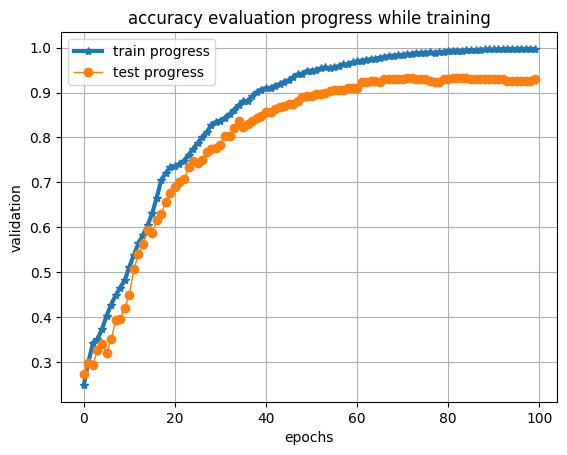

In [114]:
def plot_evaluation(train_progress, test_progress, title):
    '''function to plot the progress of training and testing data'''

    # convert the train accuracy list into numpy array.
    train_line_val = np.array([val for val in train_progress])
    # convert the train accuracy list into numpy array.
    test_line_val = np.array([val for val in test_progress])

    # plot the progress of training accuracy over epochs.
    train_progress, = plt.plot((range(len(train_line_val))), train_line_val, label="train progress", marker="*", linewidth=3)
    # plot the progress of testing accuracy over epochs.
    test_progress, = plt.plot((range(len(test_line_val))), test_line_val, label="test progress", marker="o", linewidth=1)

    # set the legend parameters.
    plt.legend(loc="best", handles=[train_progress, test_progress])
    # write the figure title.
    plt.title(title)
    # write the label of x axis.
    plt.xlabel("epochs")
    # write the label of y axis.
    plt.ylabel("validation")
    # add grid to the figure
    plt.grid(which='major')
    # to show the figure and remove any unwanted appered words
    plt.show()

plot_evaluation(evaluations_progress[:, 0, 0], evaluations_progress[:, 1, 0], 'accuracy evaluation progress while training')

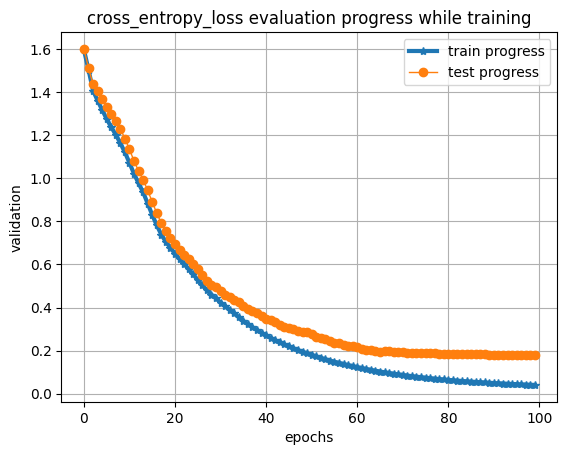

In [115]:
plot_evaluation(evaluations_progress[:, 0, 1], evaluations_progress[:, 1, 1], 'cross_entropy_loss evaluation progress while training')

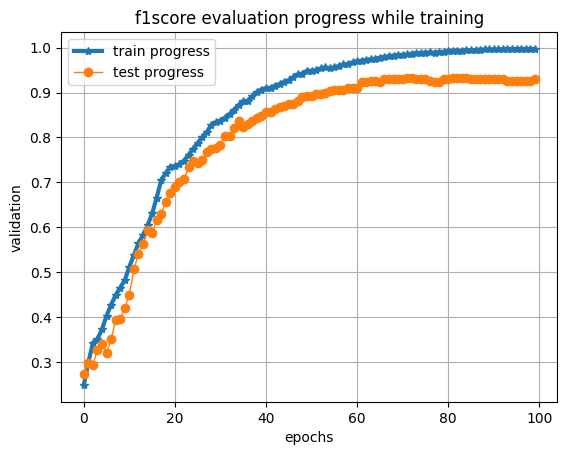

In [116]:
plot_evaluation(evaluations_progress[:, 0, 2], evaluations_progress[:, 1, 2], 'f1score evaluation progress while training')

In [121]:
# to change to this directory
%cd /content/drive/MyDrive/maids.cc/data/savings


#################################################################################
#save and load and use model using joblib
#################################################################################
# # # #save the trained model to disk
model_filename_ = 'pytorch_model_.sav'
pipe_filename_ = 'pipe_preprocessing_.sav'
# # # save the model
#joblib.dump(model, model_filename_)
# # # save the preprocessing pipe
#joblib.dump(pipe, pipe_filename_)
# # # to load the model from disk
pytorch_model = joblib.load(model_filename_)
# # # # to load the pipe from disk
pipe = joblib.load(pipe_filename_)
############
# # # inference process
xtest = pipe.transform(xtest_unprocessed)
test_labels = torch.tensor(ytest.values.astype(np.int64))
test_input = torch.tensor(xtest.astype(np.float32))
pytorch_model.eval()
output = pytorch_model(test_input)
labels = torch.argmax(output, axis=1)
print(f"accuracy = {float(sum(labels==test_labels)/len(test_labels))*100:.2f}%")
#################################################################################
#################################################################################




#################################################################################
#save and load and use model using pickle
#################################################################################
# # # another way to save the trained model
model_filename = 'pytorch_model.sav'
pipe_filename = 'pipe_preprocessing.sav'
# # # save the model
#pickle.dump(model, open(model_filename, 'wb'))
# # # save the preprocessing pipe
#pickle.dump(pipe, open(pipe_filename, 'wb'))
# # # # to load the model from disk
pytorch_model = pickle.load(open(model_filename, 'rb'))
# # # # to load the pipe from disk
pipe = pickle.load(open(pipe_filename, 'rb'))
############################
# # # inference process
#xtest = pipe.transform(xtest_unprocessed)
#test_labels = torch.tensor(ytest.values.astype(np.int64))
#test_input = torch.tensor(xtest.astype(np.float32))
#pytorch_model.eval()
#output = pytorch_model(test_input)
#labels = torch.argmax(output, axis=1)
#print(f"accuracy = {float(sum(labels==test_labels)/len(test_labels))*100:.2f}%")
#################################################################################
#################################################################################




#################################################################################
# save and load and use model using torch, but the problem is i can't save the preprocessing and can't use the pipe saved by pickle,
# but i'm sure that there is methos to save pipe using torch, but i didn't search almost at all
#################################################################################
# path to the saving file
#model_PATH = '/content/drive/MyDrive/maids.cc/data/savings/Pytorch_model.pt'
##preprocessing_PATH = '/content/drive/MyDrive/maids.cc/data/savings/Pytorch_model.pt'

# # # saving the model using pytorch refer to https://pytorch.org/tutorials/beginner/saving_loading_models.html
#torch.save(model, model_PATH)
# # # loading the model when needed
#pytorch_model = torch.load(model_PATH)
############
# # # inference process
# # # NOTE:- i'm not sure if pipe can be saved by torch but i figure out how to save it by joblib and pickle
#xtest = pipe(xtest_unprocessed)
#pytorch_model.eval()
#output = pytorch_model(xtest)
#labels = torch.argmax(output, axis=1)
#print(f"accuracy = {float(sum(labels==test_labels)/len(test_labels))*100:.2f}%")
#################################################################################
#################################################################################



# inference process
#xtest = pipe.transform(xtest_unprocessed)
#test_labels = torch.tensor(ytest.values.astype(np.int64))
#test_input = torch.tensor(xtest.astype(np.float32))
#pytorch_model.eval()
#output = pytorch_model(test_input)
#labels = torch.argmax(output, axis=1)
#print(f"accuracy = {float(sum(labels==test_labels)/len(test_labels))*100:.2f}%")

/content/drive/MyDrive/maids.cc/data/savings
accuracy = 93.00%
